In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
ratings_file = "ratings.csv"
df = pd.read_csv(ratings_file)

In [ ]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
y = df["rating"].apply(lambda x: (x- min_rating) / (max_rating - min_rating)).values
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [ ]:
EMBEDDING_SIZE = 50

class Recommender(keras.Model):
  def __init__(self, num_users, num_movies, embedding_size, **kwargs):
    super(Recommender, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = "he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.movie_embedding = layers.Embedding(
        num_movies,
        embedding_size,
        embeddings_initializer = "he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
    )
    self.movie_bias = layers.Embedding(num_movies, 1)
  
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:,0])
    movie_vector = self.movie_embedding(inputs[:,1])
    movie_bias = self.movie_bias(inputs[:,1])
    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
    x = dot_user_movie + user_bias + movie_bias

    return tf.nn.sigmoid(x)

In [ ]:
model = Recommender(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam()
)

In [ ]:
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=10, verbose=1,validation_data=(x_val,y_val))

Epoch 1/10
1418/1418 [==============================] - 8s 6ms/step - loss: 0.6078 - val_loss: 0.6136
Epoch 2/10
1418/1418 [==============================] - 6s 4ms/step - loss: 0.6084 - val_loss: 0.6146
Epoch 3/10
1418/1418 [==============================] - 4s 3ms/step - loss: 0.6103 - val_loss: 0.6131
Epoch 4/10
1418/1418 [==============================] - 4s 3ms/step - loss: 0.6064 - val_loss: 0.6180
Epoch 5/10
1418/1418 [==============================] - 4s 3ms/step - loss: 0.6088 - val_loss: 0.6182
Epoch 6/10
 288/1418 [=====>........................] - ETA: 3s - loss: 0.6192

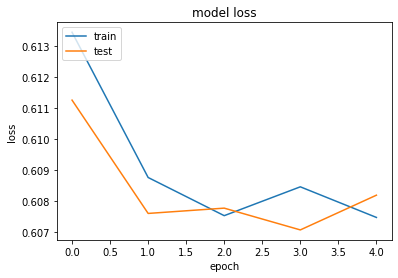

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
movie_df = pd.read_csv("movies.csv")

user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("===" * 9)
print("Movies with high ratings from user")
print("===" * 9)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 608
Movies with high ratings from user
Equilibrium (2002) : Action|Sci-Fi|Thriller
Shaun of the Dead (2004) : Comedy|Horror
Sin City (2005) : Action|Crime|Film-Noir|Mystery|Thriller
300 (2007) : Action|Fantasy|War|IMAX
Transformers (2007) : Action|Sci-Fi|Thriller|IMAX
--------------------------------
Top 10 movie recommendations
--------------------------------
Philadelphia Story, The (1940) : Comedy|Drama|Romance
Rear Window (1954) : Mystery|Thriller
North by Northwest (1959) : Action|Adventure|Mystery|Romance|Thriller
Casablanca (1942) : Drama|Romance
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) : Action|Adventure
Brazil (1985) : Fantasy|Sci-Fi
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) : Action|Adventure|Western
Lost in Translation (2003) : Comedy|Drama|Romance
Dark Knight, The (2008) : Action|Crime|Drama|IMAX
